In [ ]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from util import training, ElmanRNN, JordanRNN, MultiRecurrentNN, convert_feature_into_cyclic
from sklearn.preprocessing import RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

def preprocess(data):
    indices = data.index

    data['HourOfDay'] = data['DateTime'].dt.hour
    data['DayOfWeek'] = data['DateTime'].dt.dayofweek
    data['Month'] = data['DateTime'].dt.month
    convert_feature_into_cyclic(data, 'HourOfDay', 24)
    convert_feature_into_cyclic(data, 'DayOfWeek', 7)
    convert_feature_into_cyclic(data, 'Month', 12)
    data.drop(columns=['HourOfDay', 'DayOfWeek', 'Month','NMHC(GT)'], inplace=True)
    # use fill forward imputation for 0 values
    data = data.replace(',', '.', regex=True)
    data['PT08.S1(CO)'] = data['PT08.S1(CO)'].mask(data['PT08.S1(CO)'] < 0, np.nan)
    data['PT08.S2(NMHC)'] = data['PT08.S2(NMHC)'].mask(data['PT08.S2(NMHC)'] < 0, np.nan)
    data['NOx(GT)'] = data['NOx(GT)'].mask(data['NOx(GT)'] < 0, np.nan)
    data['NO2(GT)'] = data['NO2(GT)'].mask(data['NO2(GT)'] < 0, np.nan)
    data['PT08.S4(NO2)'] = data['PT08.S4(NO2)'].mask(data['PT08.S4(NO2)'] < 0, np.nan)
    data['PT08.S5(O3)'] = data['PT08.S5(O3)'].mask(data['PT08.S5(O3)'] < 0, np.nan)
    data = data.ffill()
    # drop because of high correlation
    data = data.drop(columns=['PT08.S1(CO)','C6H6(GT)', 'PT08.S2(NMHC)'])
    data = data[data['PT08.S3(NOx)'] > 0]
    data = data.dropna()

    indices_after = data.index
    dropped_indices = set(indices) - set(indices_after)

    return data, dropped_indices

# Read in the data
raw_data = pd.read_csv('../csvs/AirQualityUCI.csv', sep=';')
raw_data['DateTime'] = raw_data['Time'] + '/' + raw_data['Date']
raw_data['DateTime'] = pd.to_datetime(raw_data['DateTime'], format='%H.%M.%S/%d/%m/%Y')
raw_data = raw_data.sort_values(by='DateTime').reset_index(drop=True)
raw_data.drop(columns=['Time', 'Date', 'Unnamed: 15', 'Unnamed: 16'], inplace=True)
# drop rows with all NaN values
raw_data.dropna(how='all', inplace=True)
preprocessed_data = preprocess(raw_data.copy())
raw_data.head(n=100)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime
0,"2,6",1360.00,150.00,"11,9",1046.00,166.00,1056.00,113.00,1692.00,1268.00,"13,6","48,9","0,7578",2004-03-10 18:00:00
1,2,1292.00,112.00,"9,4",955.00,103.00,1174.00,92.00,1559.00,972.00,"13,3","47,7","0,7255",2004-03-10 19:00:00
2,"2,2",1402.00,88.00,"9,0",939.00,131.00,1140.00,114.00,1555.00,1074.00,"11,9","54,0","0,7502",2004-03-10 20:00:00
3,"2,2",1376.00,80.00,"9,2",948.00,172.00,1092.00,122.00,1584.00,1203.00,"11,0","60,0","0,7867",2004-03-10 21:00:00
4,"1,6",1272.00,51.00,"6,5",836.00,131.00,1205.00,116.00,1490.00,1110.00,"11,2","59,6","0,7888",2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"2,9",1438.00,156.00,"12,0",1051.00,180.00,943.00,128.00,1668.00,1206.00,"21,3","30,8","0,7696",2004-03-14 17:00:00
96,"2,5",1478.00,122.00,"12,2",1055.00,160.00,929.00,121.00,1671.00,1262.00,"19,7","36,7","0,8307",2004-03-14 18:00:00
97,"4,6",1808.00,262.00,"20,6",1312.00,261.00,753.00,157.00,1993.00,1698.00,"18,4","41,7","0,8732",2004-03-14 19:00:00
98,"5,9",1898.00,341.00,"23,1",1381.00,325.00,681.00,173.00,2103.00,1905.00,"17,6","46,1","0,9210",2004-03-14 20:00:00


In [87]:
# disable scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)
descriptions = raw_data.drop(columns=['DateTime']).describe()
descriptions.rename(columns={'avg_temp_c': 'Average Temperature (C)'}, inplace=True)
descriptions.round(2).to_csv('../csv-descriptions/airquality-stats.csv')
descriptions

,PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
count,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00
mean,1048.99,-159.09,894.60,168.62,794.99,58.15,1391.48,975.07
std,329.83,139.79,342.33,257.43,321.99,126.94,467.21,456.94
min,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
25%,921.00,-200.00,711.00,50.00,637.00,53.00,1185.00,700.00
50%,1053.00,-200.00,895.00,141.00,794.00,96.00,1446.00,942.00
75%,1221.00,-200.00,1105.00,284.00,960.00,133.00,1662.00,1255.00
max,2040.00,1189.00,2214.00,1479.00,2683.00,340.00,2775.00,2523.00


In [73]:
split_index = int(len(raw_data) * 0.7)
raw_train = raw_data.copy()[:split_index]
raw_test = raw_data.copy()[split_index:]
preprocessed_train, dropped_indices = preprocess(raw_train.copy())

In [44]:
import pickle

In [67]:
dates = preprocessed_train['DateTime']
preprocessed_train = preprocessed_train.drop(columns=['DateTime'])

In [68]:
results_elman_h32 = training(data=preprocessed_train,
         target_feature_name='PT08.S3(NOx)',
         model=ElmanRNN(input_size=raw_train.shape[1]-1, hidden_size=32, output_size=1, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)

(6401, 14)
(6401,)
(6338, 64, 14)
(6338,)
Train indices from 0 to 5070 and validation indices from 5071 to 6337


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x14 and 13x32)

In [59]:
results_jordan_h32 = training(data=preprocessed_train,
         target_feature_name='PT08.S3(NOx)',
         model=JordanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=32, output_size=1, state_size=32, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)



(6401, 14)
(6401,)
(6338, 64, 14)
(6338,)
Train indices from 0 to 5070 and validation indices from 5071 to 6337


KeyboardInterrupt: 

In [11]:
import pickle
pickle.dump(results_elman_h32, open('../pickles/airquality_results_elman_h32.pkl', 'wb'))
pickle.dump(results_jordan_h32, open('../pickles/airquality_results_jordan_h32.pkl', 'wb'))

(6481, 14)
(6481,)
(6418, 64, 14)
(6418,)
Train indices from 0 to 5134 and validation indices from 5135 to 6417
Epoch [1/100], Loss: 753152.5495, Validation Loss: 604804.9525
Epoch [2/100], Loss: 614564.8440, Validation Loss: 482556.9814
Epoch [3/100], Loss: 484256.6081, Validation Loss: 381766.6912
Epoch [4/100], Loss: 379749.1480, Validation Loss: 302473.6420
Epoch [5/100], Loss: 295802.7500, Validation Loss: 241519.7001
Epoch [6/100], Loss: 229178.0433, Validation Loss: 195942.4617
Epoch [7/100], Loss: 176578.1023, Validation Loss: 163158.9761
Epoch [8/100], Loss: 134470.3753, Validation Loss: 139732.0099
Epoch [9/100], Loss: 107838.2592, Validation Loss: 124391.7538
Epoch [10/100], Loss: 88361.9241, Validation Loss: 114815.4378
Epoch [11/100], Loss: 71712.2646, Validation Loss: 102113.4436
Epoch [12/100], Loss: 66125.4587, Validation Loss: 90095.7715
Epoch [13/100], Loss: 53054.9650, Validation Loss: 80049.3535
Epoch [14/100], Loss: 42567.8714, Validation Loss: 73063.1131
Epoch [15

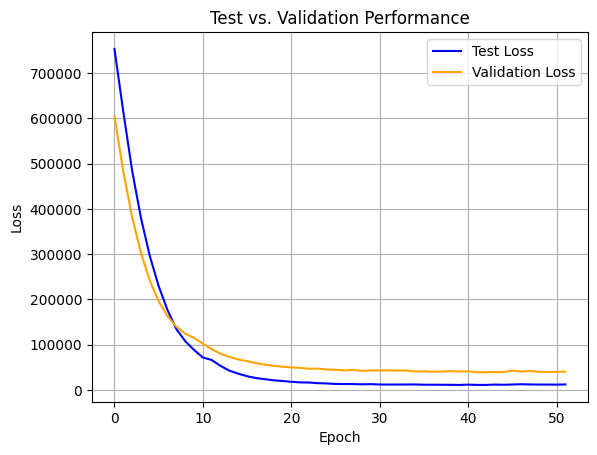

In [ ]:
results_elman_h64 = training(data=preprocessed_train,
         target_feature_name='PT08.S3(NOx)',
         model=ElmanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=64, output_size=1, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.005,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)

(6481, 14)
(6481,)
(6418, 64, 14)
(6418,)
Train indices from 0 to 5134 and validation indices from 5135 to 6417
Epoch [1/100], Loss: 629303.0947, Validation Loss: 363653.5178
Epoch [2/100], Loss: 220324.5394, Validation Loss: 137239.1770
Epoch [3/100], Loss: 78439.9042, Validation Loss: 111499.6650
Epoch [4/100], Loss: 55558.3649, Validation Loss: 110693.0078
Epoch [5/100], Loss: 48720.9238, Validation Loss: 101057.1836
Epoch [6/100], Loss: 41689.6302, Validation Loss: 81723.7508
Epoch [7/100], Loss: 33224.5688, Validation Loss: 70420.2438
Epoch [8/100], Loss: 25210.4134, Validation Loss: 60303.7679
Epoch [9/100], Loss: 22815.9083, Validation Loss: 57758.5430
Epoch [10/100], Loss: 19777.5996, Validation Loss: 54936.9853
Epoch [11/100], Loss: 20390.8691, Validation Loss: 51942.2600
Epoch [12/100], Loss: 19460.5700, Validation Loss: 50616.6768
Epoch [13/100], Loss: 18216.9690, Validation Loss: 49237.6839
Epoch [14/100], Loss: 17206.0354, Validation Loss: 47688.3758
Epoch [15/100], Loss: 

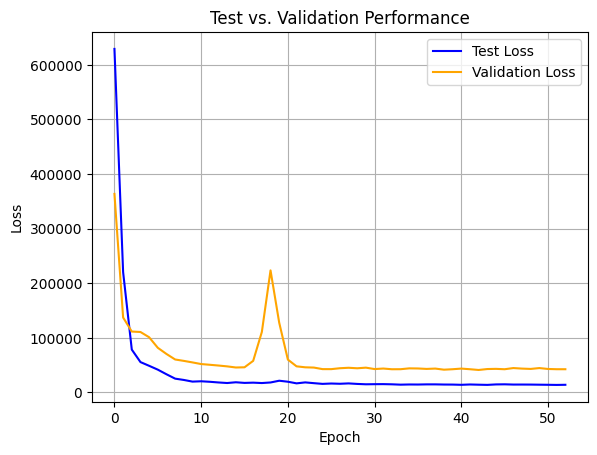

In [ ]:
results_jordan_h64 = training(data=preprocessed_train,
         target_feature_name='PT08.S3(NOx)',
         model=JordanRNN(input_size=preprocessed_train.shape[1]-1, hidden_size=64, output_size=1, state_size=32, dropout=0.2),
         num_epochs=100,
         # Reduced because of noise
         splits=4,
         patience=10,
         scaler_X=RobustScaler(),
         optimizer_learning_rate=0.05,
         optimizer_weight_decay=1e-5,
         optimizer_b1=0.6,
         optimizer_b2=0.999,
         use_final_fold=True)



In [18]:
import pickle
pickle.dump(results_elman_h64, open('../pickles/airquality_results_elman_h64.pkl', 'wb'))
pickle.dump(results_jordan_h64, open('../pickles/airquality_results_jordan_h64.pkl', 'wb'))

In [6]:
airquality_jordan_h32_results = pickle.load(open('../pickles/airquality_results_jordan_h32.pkl', 'rb'))
airquality_elman_h32_results = pickle.load(open('../pickles/airquality_results_elman_h32.pkl', 'rb'))

In [85]:
processed_test, dropped_indices = preprocess(raw_test.copy())
processed_test.drop(columns=['DateTime'], inplace=True)

/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


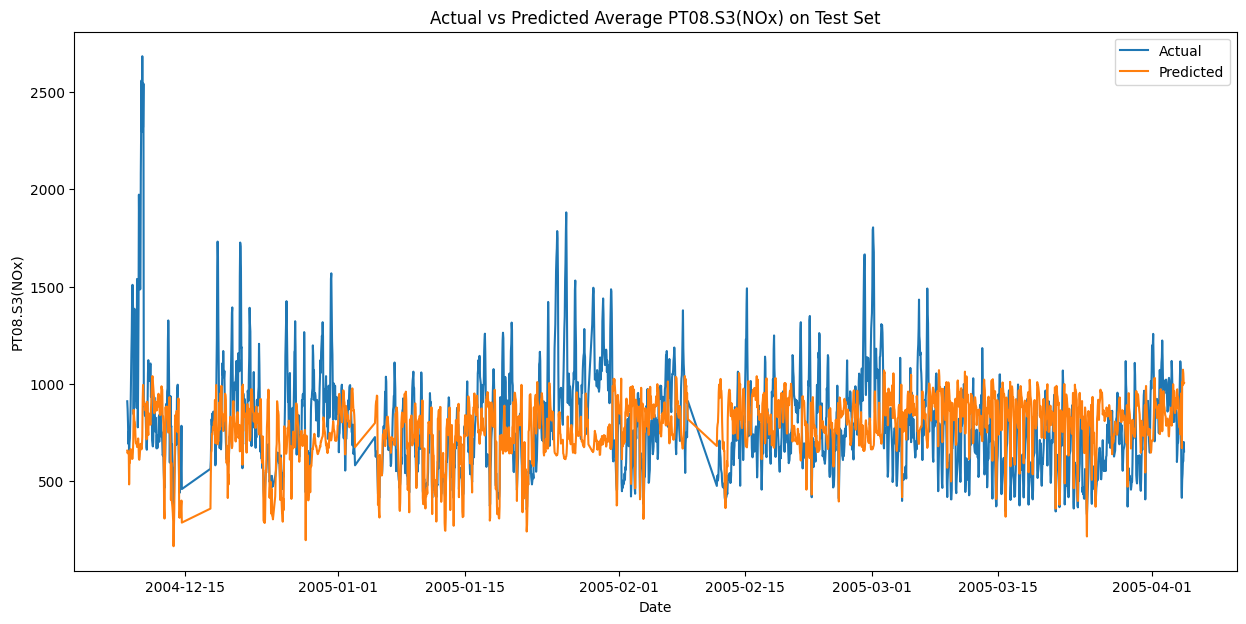

/home/christopher/Git/Machine-Learning-Assignment-3/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


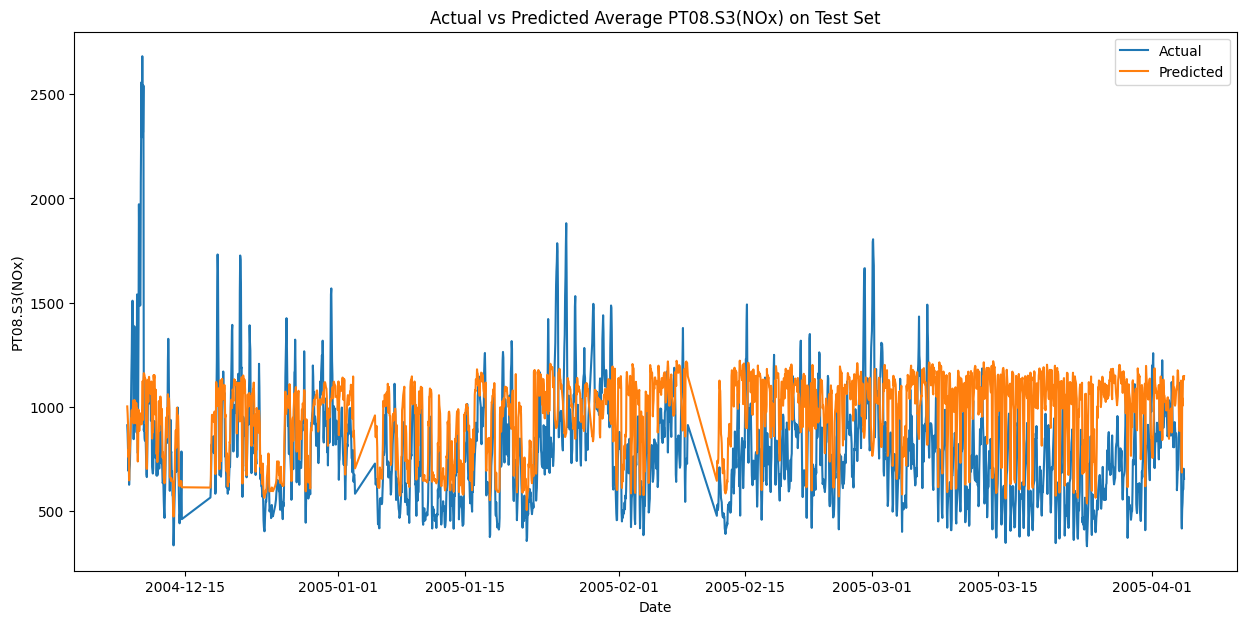

,Mean,Std. Dev.,Min,25%,Median,75%,Max
JordanRNN H32 AirQuality,220.80,192.22,0.27,89.03,185.88,299.65,1954.35
ElmanRNN H32 AirQuality,256.09,169.88,1.14,134.82,223.82,365.41,1670.03


In [86]:
from util import get_predictions

r1 = get_predictions(raw_test=raw_test, 
                     preprocessed_test=processed_test, 
                     results=airquality_jordan_h32_results, 
                     model_name='JordanRNN H32 AirQuality',
                     xlabel='Date',
                     ylabel='PT08.S3(NOx)',
                     title='Actual vs Predicted Average PT08.S3(NOx) on Test Set',
                     target_feature_name='PT08.S3(NOx)',
                     save_path='../images/airquality-jordan-h32-actual-vs-predicted.pdf',
                     show_plot=True)
r2 = get_predictions(raw_test=raw_test, 
                     preprocessed_test=processed_test, 
                     results=airquality_elman_h32_results, 
                     model_name='ElmanRNN H32 AirQuality',
                     xlabel='Date',
                     ylabel='PT08.S3(NOx)',
                     target_feature_name='PT08.S3(NOx)',
                     title='Actual vs Predicted Average PT08.S3(NOx) on Test Set',
                     save_path='../images/airquality-elman-h32-actual-vs-predicted.pdf',
                     show_plot=True)
results = pd.concat([r1, r2])
results.round(2).to_csv('../csv-descriptions/airquality-rnn-results-raw.csv', index=False)
results.round(2)